In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit

from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters 

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
cavity_path = "../data/2021_03_24_received_cavity-spectrometer/cavity-spectrometer/L_B_a_1_post_tune_1_1800gr_100ms_734.00nm_2.00mm.txt"
siv_path = "../data/2021_03_24_received_cavity-spectrometer/siv4/sweeper_bwd_scans_"
siv_files = ["13_41_57.txt", "13_42_43.txt", "13_43_30.txt", "13_45_05.txt", "13_45_54.txt", "13_46_44.txt", "13_47_34.txt", "13_48_22.txt", "13_49_11.txt", "13_50_00.txt"]

# Plot Cavity Data 

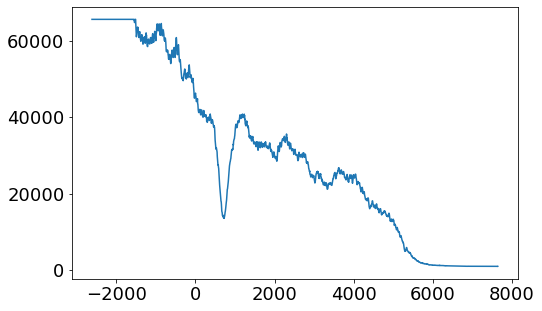

In [3]:
cavity_data = np.loadtxt(cavity_path, skiprows=2, delimiter=",")
lambdas, cavity_counts = cavity_data.T
cavity_freqs = 2.998E8 / lambdas - 406000 # GHz
plt.plot(cavity_freqs, cavity_counts)

## Plot SiV Data

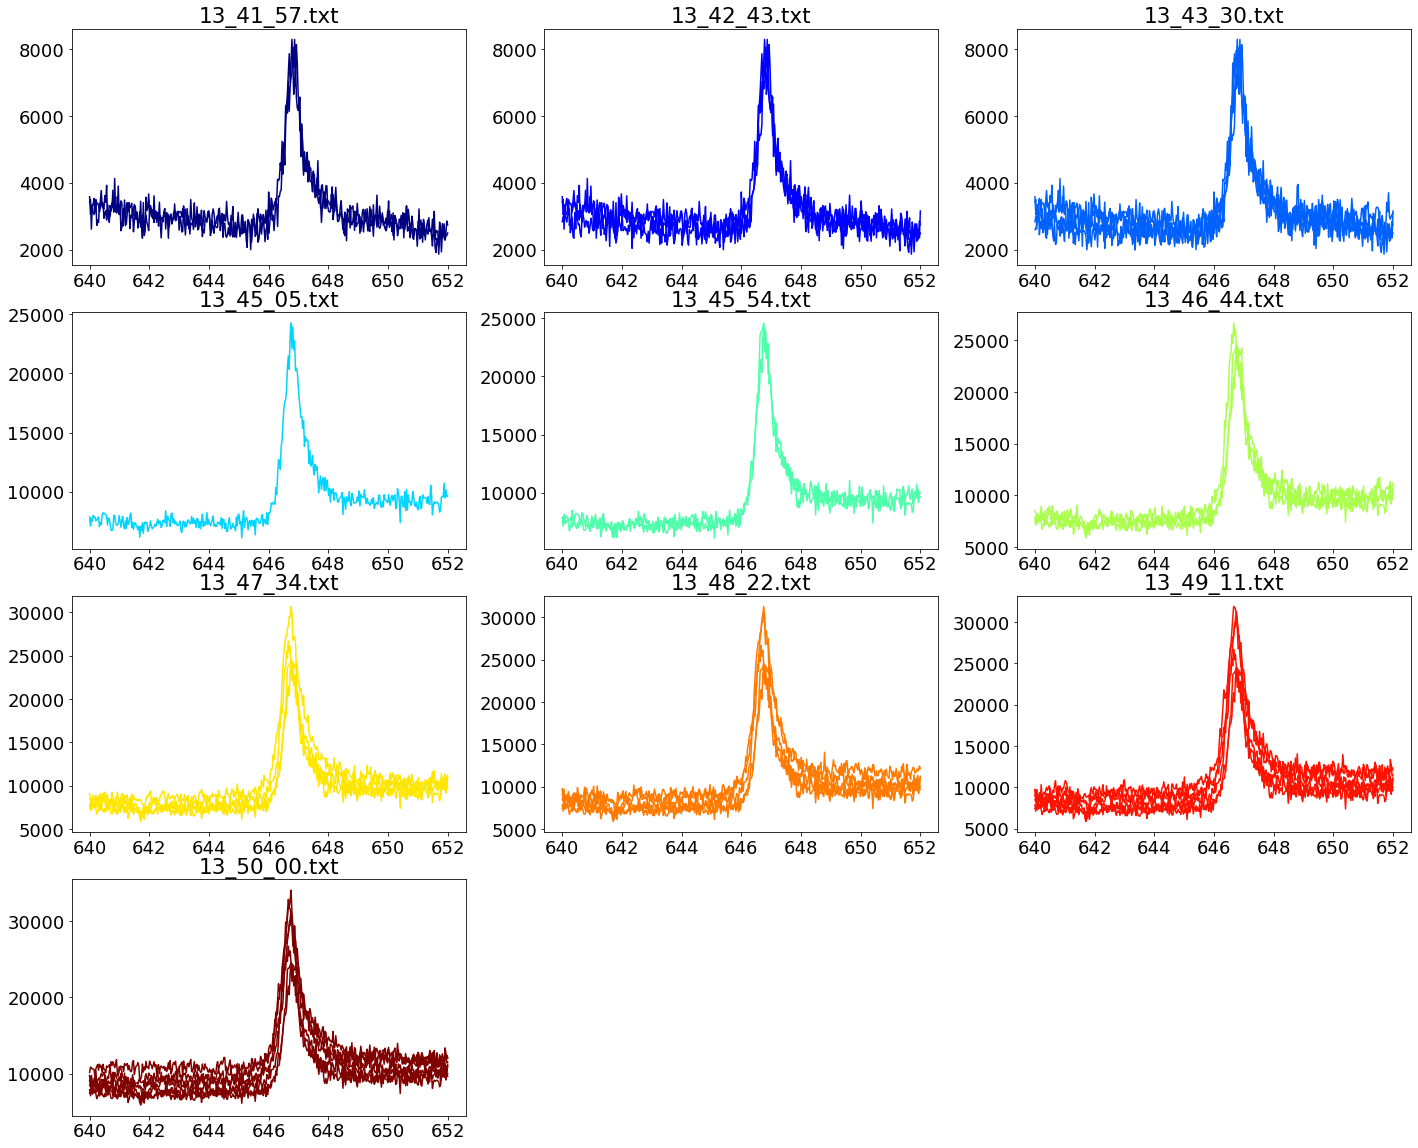

In [4]:
siv_freqs = np.linspace(640, 652, 401) # GHz

color = plt.cm.jet(np.linspace(0, 1, len(siv_files)))
plt.figure(figsize=[24, 20])

for i, file in enumerate(siv_files):
    siv_data = np.loadtxt(siv_path + file)
    if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

    plt.subplot(4, 3, i+1)
    plt.gca().title.set_text(file)
    
    for siv_series in siv_data:
        plt.plot(siv_freqs, siv_series, c=color[i])

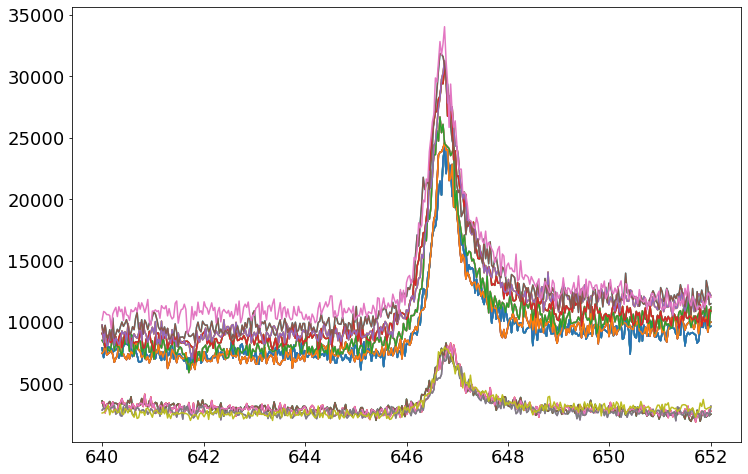

In [5]:
plt.figure(figsize=[12, 8])
for file in siv_files:
    siv_data = np.loadtxt(siv_path + file)
    if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))
    
    for siv_series in siv_data:
        plt.plot(siv_freqs, siv_series)

# Fit Peaks

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 121
    # variables        = 5
    chi-square         = 1.0741e+08
    reduced chi-square = 925939.253
    Akaike info crit   = 1667.25999
    Bayesian info crit = 1681.23894
##  Warning: uncertainties could not be estimated:
    B:      at boundary
[[Variables]]
    w_c:    721.856719 (init = 700)
    k_in:   127.404091 (init = 100)
    k_tot:  164.084496 (init = 100)
    A:      44445.0327 (init = 40000)
    B:      0.00000000 (init = 0)


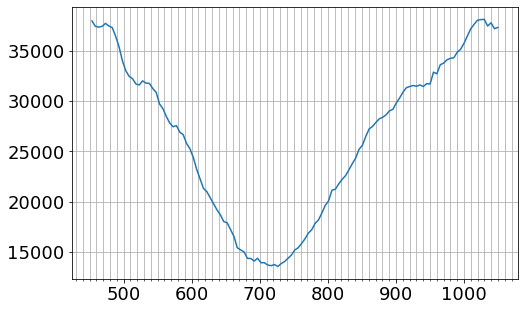

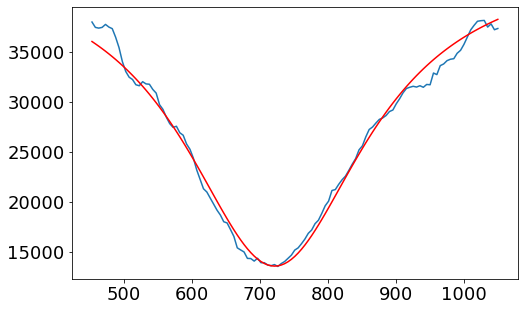

In [22]:
freq_lo = 450
freq_hi = 1050

cavity_freqs_filtered = cavity_freqs[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
cavity_counts_filtered = cavity_counts[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)

plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(5000))
plt.grid(which='both')

##############################

params = Parameters()
params.add_many(
    Parameter('w_c', value=700, min=690, max=730),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=100, min=0, max=1000),
    Parameter('A', value=40000, min=0, max=50000),
    Parameter('B', value=0, min=0, max=100),
)

results = fitter.fit_reflection(params, cavity_freqs_filtered, cavity_counts_filtered, fit_func=fitter.cavity_ref)
lmfit.report_fit(results)

# Compare actual data with fit. Have to add the y-data to the prediction since the function subtracted the y-data 
# in its definition (so that it can try to minimize that function value)
# Alternative: plt.plot(cavity_freqs_filtered, cavity_counts_filtered + results.residual, 'r')
plt.figure()
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)
plt.plot(cavity_freqs_filtered, fitter.cavity_ref(results.params, cavity_freqs_filtered, cavity_counts_filtered) + cavity_counts_filtered, 'r')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 50
    # variables        = 5
    chi-square         = 3657428.73
    reduced chi-square = 81276.1940
    Akaike info crit   = 570.012396
    Bayesian info crit = 579.572511
##  Warning: uncertainties could not be estimated:
    B:      at boundary
[[Variables]]
    w_c:    715.953190 (init = 700)
    k_in:   124.663724 (init = 100)
    k_tot:  159.382295 (init = 100)
    A:      42637.1733 (init = 40000)
    B:      0.00000000 (init = 0)


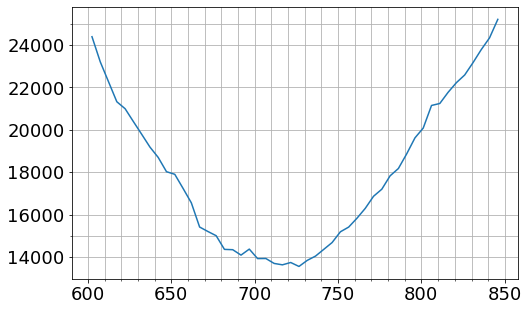

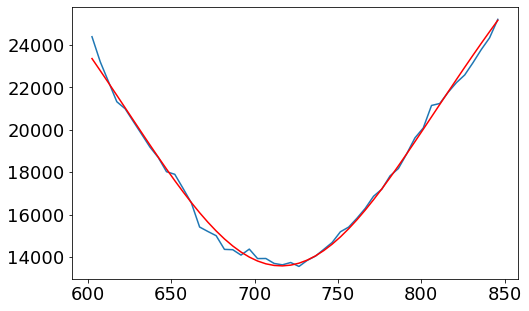

In [23]:
freq_lo = 600
freq_hi = 850

cavity_freqs_filtered = cavity_freqs[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
cavity_counts_filtered = cavity_counts[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)

plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(5000))
plt.grid(which='both')

##############################

params = Parameters()
params.add_many(
    Parameter('w_c', value=700, min=690, max=730),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=100, min=0, max=1000),
    Parameter('A', value=40000, min=0, max=50000),
    Parameter('B', value=0, min=0, max=100),
)

results = fitter.fit_reflection(params, cavity_freqs_filtered, cavity_counts_filtered, fit_func=fitter.cavity_ref)
lmfit.report_fit(results)

plt.figure()
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)
plt.plot(cavity_freqs_filtered, cavity_counts_filtered + results.residual, 'r')

## Fitting first SiV

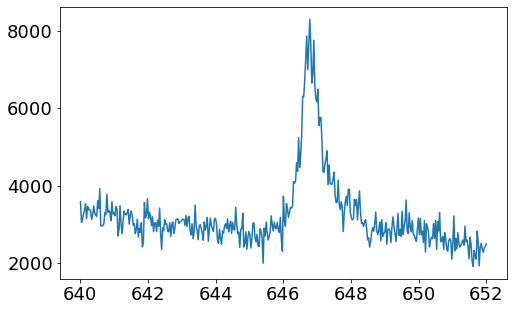

In [6]:
siv_data = np.loadtxt(siv_path + siv_files[0])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))
plt.plot(siv_freqs, siv_data[0])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1302
    # data points      = 401
    # variables        = 8
    chi-square         = 30394698.8
    reduced chi-square = 77340.2006
    Akaike info crit   = 4521.56275
    Bayesian info crit = 4553.51445
##  Warning: uncertainties could not be estimated:
    B:         at boundary
[[Variables]]
    w_up:      646.719966 (init = 647)
    g_up:      2.56857721 (init = 5.6)
    gamma_up:  0.28969830 (init = 0.1)
    w_c:       656.890179 (init = 715)
    k_in:      99.9978562 (init = 20)
    k_tot:     225.139370 (init = 33)
    A:         192401.841 (init = 6000)
    B:         0.00000000 (init = 0)


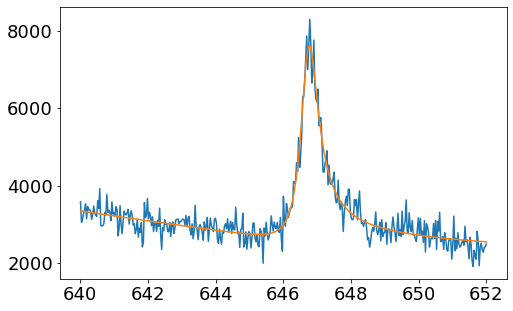

In [28]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=647, min=646, max=648),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=20, min=0, max=100),
    Parameter('k_tot', value=33, min=0, max=250),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0, min=0, max=100),
)

results = fitter.fit_reflection(params, siv_freqs, siv_data[0], fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_data[0])
plt.plot(siv_freqs, siv_data[0] + results.residual)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 459
    # data points      = 401
    # variables        = 7
    chi-square         = 30455977.4
    reduced chi-square = 77299.4351
    Akaike info crit   = 4520.37039
    Bayesian info crit = 4548.32812
##  Warning: uncertainties could not be estimated:
    B:         at boundary
[[Variables]]
    w_up:      646.721169 (init = 647)
    g_up:      2.57558799 (init = 5.6)
    gamma_up:  0.27794809 (init = 0.1)
    w_c:       656.110641 (init = 715)
    k_in:      67.5736624 (init = 20)
    k_tot:     159.38 (fixed)
    A:         105174.431 (init = 6000)
    B:         0.00000000 (init = 0)


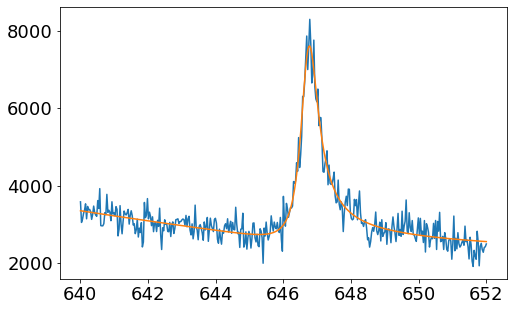

In [26]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=647, min=646, max=648),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=20, min=0, max=100),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0, min=0, max=100),
)

results = fitter.fit_reflection(params, siv_freqs, siv_data[0], fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_data[0])
plt.plot(siv_freqs, siv_data[0] + results.residual)

## File 3/2 13:12

{'w_up_1': 614.9999999998715, 'g_up_1': 3.5475283405989013, 'gamma_up_1': 4.999999999999999, 'w_up_2': 623.8552979859932, 'g_up_2': 1.0000000000000002, 'gamma_up_2': 0.0841631908628212, 'w_up_3': 634.9999999999999, 'g_up_3': 9.703118539773422, 'gamma_up_3': 4.999999999999999, 'w_c': 609.5117567151198, 'k_in': 6.497972911358297, 'k_tot': 11.442073379322986, 'A': 34435.05257259719, 'B': 9999.999999999998}


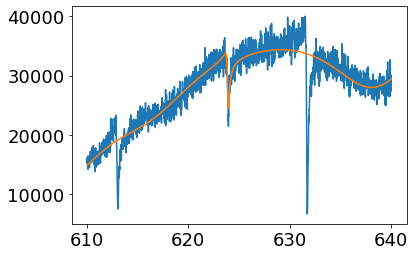

In [38]:
data = np.loadtxt("../data/03_02_sweeper_fwd_avg_13_12_30/sweeper_fwd_avg_13_12_30.txt")
freqs, counts = data
freqs = 1000 * (freqs - 406)
plt.plot(freqs, counts)

#w_up_1, g_up_1, gamma_up_1, w_up_2, g_up_2, gamma_up_2, w_up_3, g_up_3, gamma_up_3, w_c, k_in, k_tot, A, B
popt, cov = fitter.fit_reflection(freqs, counts, fit_func=fitter.three_siv_ref,
                            p0= [615, 5.6, 0.1, 625, 5.6, 0.1, 632, 5.6, 0.1, 500,  20,  33, 40000, 0], 
                        bounds=([610, 1, 0, 620, 1, 0, 630, 1, 0, 0, 0, 0, 5000, 0], 
                                [615, 20, 5, 628, 20, 5, 635, 20, 5, 1000, 100, 100, 100000, 10000]))

print(popt)
plt.plot(freqs, fitter.three_siv_ref(freqs, **popt))
plt.show()

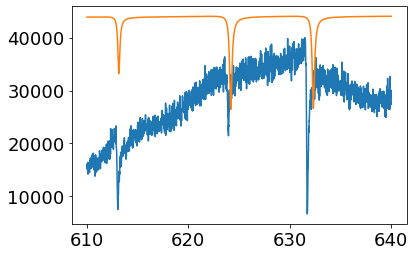

In [45]:
# Put in random values by hand
plt.plot(freqs, counts)
plt.plot(freqs, fitter.three_siv_ref(freqs, **{'w_up_1': 612.9999999998715, 'g_up_1': 3.5475283405989013, 'gamma_up_1': 0.1, 'w_up_2': 623.8552979859932, 'g_up_2': 5.6, 'gamma_up_2': 0.1, 'w_up_3': 632, 'g_up_3': 5.6, 'gamma_up_3': 0.1, 'w_c': 528.5117567151198, 'k_in': 6.497972911358297, 'k_tot': 11.442073379322986, 'A': 34435.05257259719, 'B': 9999.999999999998}))
plt.show()

{'w_up': 612.8787336757835, 'g_up': 1.0000000000000002, 'gamma_up': 0.005515935600909081, 'w_c': 607.0255761968413, 'k_in': 3.7683461469227697, 'k_tot': 4.474467192414809, 'A': 22983.36380075519, 'B': 4.740840152082232e-05}


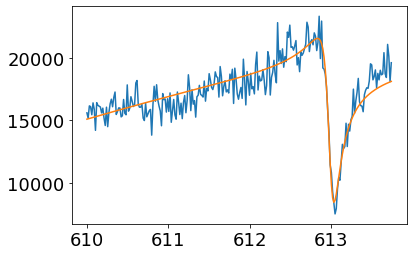

In [16]:
data = np.loadtxt("../data/03_02_sweeper_fwd_avg_13_12_30/sweeper_fwd_avg_13_12_30.txt")
freqs, counts = data
freqs = 1000 * (freqs - 406)

freqs = freqs[:250]
counts = counts[:250]
plt.plot(freqs, counts)

# w_up_1, g_up_1, gamma_up_1, w_c, k_in, k_tot, A, B
popt, cov = fitter.fit_reflection(freqs, counts, 
                             p0= [613, 5.6, 0.1, 620,  20,  33, 20000, 0], 
                        bounds=([600,   1, 0,     0,   0,   0, 5000, 0], 
                                [700,  20, 5,  1000,  100, 100, 100000, 10000]))

print(popt)
plt.plot(freqs, fitter.single_siv_ref(freqs, **popt))
plt.show()

{'w_up': 623.8081437073256, 'g_up': 1.0000000000000002, 'gamma_up': 0.08826419381092478, 'w_c': 614.8941699453056, 'k_in': 0.9319925365672616, 'k_tot': 3.863159944972196, 'A': 36672.28266922047, 'B': 2.9649863277368942e-05}


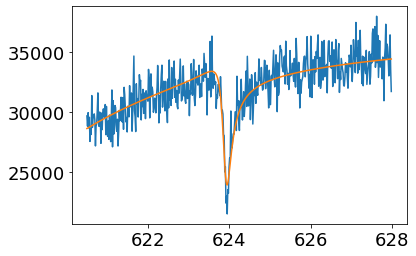

In [18]:
data = np.loadtxt("../data/03_02_sweeper_fwd_avg_13_12_30/sweeper_fwd_avg_13_12_30.txt")
freqs, counts = data
freqs = 1000 * (freqs - 406)

freqs = freqs[700:1200]
counts = counts[700:1200]
plt.plot(freqs, counts)

# w_up_1, g_up_1, gamma_up_1, w_c, k_in, k_tot, A, B
popt, cov = fitter.fit_reflection(freqs, counts, 
                             p0= [624, 5.6, 0.1, 500,  20,  33, 20000, 0], 
                        bounds=([600,   1, 0,     0,   0,   0, 5000, 0], 
                                [700,  20, 5,  1000,  100, 100, 100000, 10000]))

print(popt)
plt.plot(freqs, fitter.single_siv_ref(freqs, **popt))
plt.show()

{'w_up': 631.4743045660052, 'g_up': 7.207559364147528, 'gamma_up': 9.16794691078176e-33, 'w_c': 419.17106079235316, 'k_in': 70.8746414441822, 'k_tot': 99.99999999999999, 'A': 35434.64598704636, 'B': 2119.6459747296262}


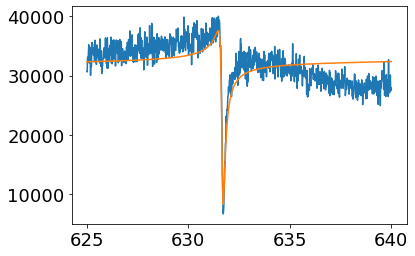

In [20]:
data = np.loadtxt("../data/03_02_sweeper_fwd_avg_13_12_30/sweeper_fwd_avg_13_12_30.txt")
freqs, counts = data
freqs = 1000 * (freqs - 406)

freqs = freqs[1000:]
counts = counts[1000:]
plt.plot(freqs, counts)

# w_up_1, g_up_1, gamma_up_1, w_c, k_in, k_tot, A, B
popt, cov = fitter.fit_reflection(freqs, counts, 
                             p0= [631, 5.6, 0.1, 620,  20,  33, 40000, 0], 
                        bounds=([600,   1, 0,     0,   0,   0, 5000, 0], 
                                [700,  20, 5,  1000,  100, 100, 100000, 10000]))

print(popt)
plt.plot(freqs, fitter.single_siv_ref(freqs, **popt))
plt.show()